In [17]:
import torch
import matplotlib.pyplot as plt

import math

from pfns.model import bar_distribution
from pfns.train import train, MainConfig, OptimizerConfig, TransformerConfig, BatchShapeSamplerConfig
from pfns.model.encoders import EncoderConfig
from pfns.model.bar_distribution import BarDistributionConfig
from pfns.priors.prior import AdhocPriorConfig
from pfns.priors import Batch

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'

In [60]:
def get_polynomial_batch(batch_size=1, seq_len=100, hyperparameters=None, device='cpu', **kwargs):
    order = hyperparameters.get('order', 20)

    ws = torch.distributions.Normal(torch.ones(order + 1), 1).sample((batch_size,))
    xs = torch.rand(batch_size, seq_len, 1) * 2 - 1
    powers = torch.stack([xs**i for i in range(order + 1)], dim=-1)
    ws_expanded = ws[:, None, None, :]
    ys = (powers * ws_expanded).sum(dim=-1)

    return Batch(x=xs.to(device), y=ys.to(device), target_y=ys.to(device))

def get_fourier_batch(batch_size=1, seq_len=100, hyperparameters=None, device='cpu', seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)
    order = hyperparameters.get('order', 20)

    coeff_scale = hyperparameters.get('coeff_scale', 1.0)
    a0 = torch.randn(batch_size, 1) * coeff_scale
    a  = torch.randn(batch_size, order) * coeff_scale
    b  = torch.randn(batch_size, order) * coeff_scale

    xs = torch.rand(batch_size, seq_len, 1) * 2 - 1

    ks = torch.arange(1, order + 1, dtype=xs.dtype, device=xs.device)
    kxs = xs[..., 0:1] * ks

    cos_terms = torch.cos(kxs)
    sin_terms = torch.sin(kxs)

    ys = (
        a0[:, None, :] +
        (a[:, None, :] * cos_terms).sum(dim=-1, keepdim=True) +
        (b[:, None, :] * sin_terms).sum(dim=-1, keepdim=True)
    )

    return Batch(
        x=xs.to(device),
        y=ys.to(device),
        target_y=ys.to(device),
    )

In [4]:
def train_a_pfn(
    get_batch_function, 
    epochs, 
    steps_per_epoch,
    num_features, 
    max_dataset_size,
    save_dir,
    hps=dict(),
    test_hps=dict(),
    batch_size=256, 
):

    ys = get_batch_function(10000, 20, hyperparameters=hps).target_y
    borders = bar_distribution.get_bucket_borders(num_outputs=1_000, ys=ys).tolist()

    run_suffix = '_'.join([f'{key}={value}' for key, value in hps.items()]) + '_test_' + '_'.join([f'{key}={value}' for key, value in test_hps.items()])

    config = MainConfig(
        priors=[AdhocPriorConfig(get_batch_methods=[get_batch_function], prior_kwargs={'hyperparameters': hps})],
        optimizer=OptimizerConfig('adamw', lr=.0003),
        model=TransformerConfig(
            criterion=BarDistributionConfig(full_support=True, borders=borders),
            emsize=512, 
            nhead=8, 
            nhid=1024, 
            nlayers=6,
            features_per_group=num_features, 
            attention_between_features=False,
            encoder=EncoderConfig(constant_normalization_mean=.5, constant_normalization_std=math.sqrt(1/12),)
        ),
        batch_shape_sampler=BatchShapeSamplerConfig(
            batch_size=batch_size, 
            max_seq_len=max_dataset_size,
            min_num_features=num_features, 
            max_num_features=num_features
        ),
        epochs=epochs, 
        warmup_epochs=epochs//4, 
        steps_per_epoch=steps_per_epoch,
        num_workers=0,
        validation_period=1,
        test_priors=[AdhocPriorConfig(get_batch_methods=[get_batch_function], prior_kwargs={'hyperparameters': test_hps})],
        tensorboard_path=f'./tensorboard/{save_dir}_{run_suffix}/',
        train_state_dict_save_path=f'./checkpoints/{save_dir}_{run_suffix}.pt',
        # verbose=False,
    )
    train_result = train(config, device='cuda', reusable_config=False)

    torch.save(train_result['model'], f'./checkpoints/model_{save_dir}_{run_suffix}.pt')
    return train_result

In [43]:
def plot_test_predictions(ax, trained_model, batch_fn, **kwargs):
    batch = get_fourier_batch(batch_size=1, **kwargs)

    batch_index = 0
    num_training_points = 20

    train_x = batch.x[batch_index, :num_training_points]
    train_y = batch.y[batch_index, :num_training_points]
    test_x = batch.x[batch_index]

    with torch.no_grad():
        # we add our batch dimension, as our transformer always expects that
        logits = trained_model(train_x[None], train_y[None], test_x[None])

    # the model has the criterion still attached (it is the same though, as our criterion above)
    # the criterion has a lot of handy function to use these logits
    pred_means = trained_model.criterion.mean(logits)[0]
    pred_confs = trained_model.criterion.quantile(logits)[0]

    ax.scatter(train_x[...,0],train_y)
    order_test_x = test_x[...,0].argsort()
    ax.plot(test_x[order_test_x, ..., 0],pred_means[order_test_x], color='green', label='pfn')
    ax.fill_between(test_x[order_test_x,0], pred_confs[...,0][order_test_x], pred_confs[...,1][order_test_x], alpha=.1, color='green')

    ax.scatter(batch.x[batch_index], batch.y[batch_index], alpha=0.5, color='orange', label='ground truth')
    ax.scatter(train_x, train_y, color='green', label='in-context example')
    ax.legend()

In [52]:
def load_tensorboard_dataframe(event_path):
    event_path = event_path + sorted(os.listdir(event_path))[-1]

    ea = EventAccumulator(event_path)
    ea.Reload()

    dfs = []
    for tag in ea.Tags()['scalars']:
        scalars = ea.Scalars(tag)
        df = pd.DataFrame({
            "step": [s.step for s in scalars],
            "value": [s.value for s in scalars],
            "tag": tag,
        })
        dfs.append(df)

    return pd.concat(dfs)

def plot_tag(ax, df, tag, **kwargs):
    ax.plot(df.loc[df.tag == tag, 'step'], df.loc[df.tag == tag, 'value'], **kwargs)


In [ ]:
train_result = train_a_pfn(get_batch_function=get_fourier_batch, epochs=10, steps_per_epoch=2, num_features=1, max_dataset_size=100, save_dir='fourier', hps={'order': 10}, test_hps={'order': 25}, batch_size=256)

init dist
Not using distributed
ALL: Using device cuda.
Tensorboard logging to: ./tensorboard/fourier_order=10_test_order=25/
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.get_fourier_batch (batch_size=1, seq_len=100, hyperparameters=None, device='cpu', **kwargs)
), hyperparameters={'order': 10}), 'num_steps': 2, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=256, min_single_eval_pos=0, max_seq_len=100, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 0, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cuda', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.get_fourier_batch (batch_size=1, seq_len=100, hyperparameters=None, device='cpu', **kwargs)
), hyperparameters={'order': 25}), 'num_

In [56]:
train_orders = [5, 15, 25]
test_order = 15

train_results = []
for train_order in train_orders:
  train_results.append(train_a_pfn(
    get_batch_function=get_fourier_batch, 
    epochs=10,
    steps_per_epoch=100,
    num_features=1, 
    max_dataset_size=100, 
    save_dir='fourier', 
    hps={'order': train_order}, 
    test_hps={'order': test_order}, 
    batch_size=256
  ))

init dist
Not using distributed
ALL: Using device cuda.
Tensorboard logging to: ./tensorboard/fourier_order=5_test_order=15/
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.get_fourier_batch (batch_size=1, seq_len=100, hyperparameters=None, device='cpu', **kwargs)
), hyperparameters={'order': 5}), 'num_steps': 100, 'batch_shape_sampler_function': <bound method BatchShapeSamplerConfig.sample_batch_shape of BatchShapeSamplerConfig(batch_size=256, min_single_eval_pos=0, max_seq_len=100, min_num_features=1, max_num_features=1, fixed_num_test_instances=None, seed=42)>, 'num_workers': 0, 'persistent_workers': True, 'get_batch_kwargs': {'device': 'cuda', 'n_targets_per_input': 1}, 'epoch_count': 0, 'importance_sampling_infos': None}
DataLoader.__dict__ {'get_batch_method': functools.partial(get_batch_sequence(
	<__main__.get_fourier_batch (batch_size=1, seq_len=100, hyperparameters=None, device='cpu', **kwargs)
), hyperparameters={'order': 15}), 'num_

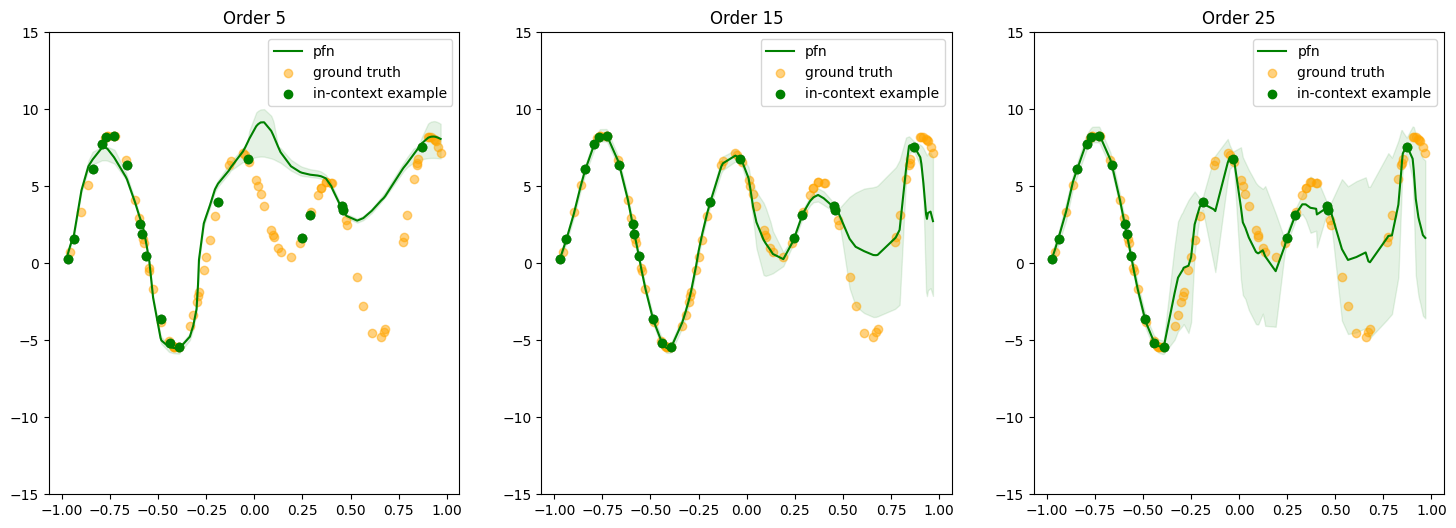

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, train_order in enumerate(train_orders):
  ax[i].set_ylim(-15, 15)
  plot_test_predictions(ax[i], train_results[i]['model'], get_fourier_batch, seq_len=100, hyperparameters={'order': test_order}, seed=99999)
  ax[i].set_title(f'Order {train_order}')

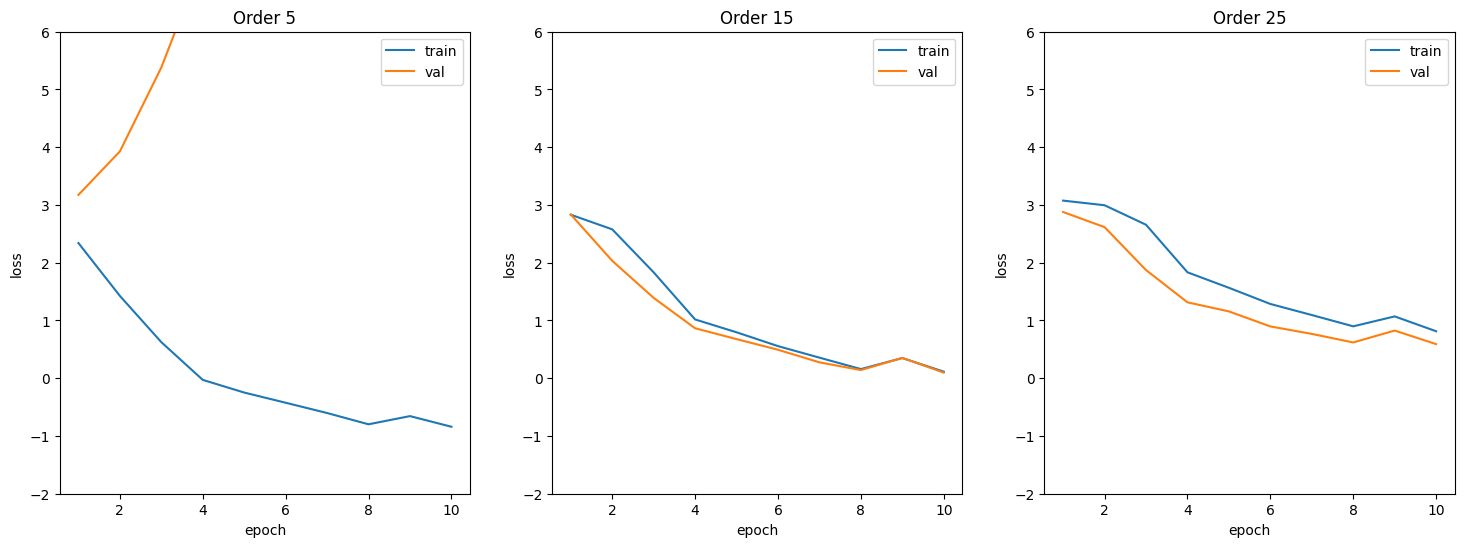

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

y_min = 100
y_max = 0
for i, train_order in enumerate(train_orders):
  ax[i].set_ylim(-2, 6)
  df = load_tensorboard_dataframe(f"/nas/ucb/vatsalb/PFNs/tensorboard/fourier_order={train_order}_test_order={test_order}/")
  plot_tag(ax[i], df, 'epoch/train_loss', label='train')
  plot_tag(ax[i], df, 'epoch/val_loss', label='val')
  ax[i].set_xlabel("epoch")
  ax[i].set_ylabel("loss")
  ax[i].legend()
  ax[i].set_title(f'Order {train_order}')